# Implementing $\pi_{\rm int} + \pi_{\rm OU}$ on the semi-circle
Simulation of agent following pheromone along a semi-circle connecting points A and B for a given distance/angle followed by exploration under OU policy. The agent lays pheromone on the way back if it succeeds in reaching Point B.

In [3]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import time
import pandas as pd

import importlib
# Function for plots
import plotFns as pF
# Parameters in the model
import prmts as pR

In [4]:
global colors
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

 ## <a class="anchor" id="first-bullet">Single agent learning using epsilon-greedy policy</a>


In [12]:
# Pheromone initial condition and class definition
p = pR.params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])
phm = phrmn(cInit)

## Agent following $\epsilon$-greedy policy

### Comparison between theoretical and TD(0)-learning $v_{\rm full}(s_c)$

In [2]:
# Agent class
class fullAgent():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.rx = p.rInit[0] #position of agent
        self.ry = p.rInit[1] #position of agent
        self.rEff = p.rInit #effective position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent
        self.valFn = np.zeros(p.nPtn) #value function initialized to zero
        self.phiSc = 0. #Angle at which bifurcation happens
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.rEff[1], self.rEff[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.rEff += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.rwd += np.exp(-phi/p.phiSt)*p.l
        
        if np.linalg.norm(self.rEff) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.rEff += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.rEff) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.rEff += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        # self.r = p.rInit
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.rx += -p.l
        self.ry += p.l*np.sin(self.thet)
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*np.pi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        if self.sInd == p.nSc + (2*np.cos(p.nSc*p.l/2)//p.l):
            if np.abs(self.ry) <= 0.5*p.sigma:
                self.rwd += (np.pi - self.phiSc)*p.a
                self.sInd = p.nSteps
            else:
                self.sInd = p.nSteps
        if np.abs(self.rx) > (p.a+p.pt+0.1):
            self.sInd = p.nSteps
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.rx = p.rInit[0] #position of agent
        self.ry = p.rInit[1] #position of agent
        self.rEff = p.rInit
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent

In [ ]:
importlib.reload(pF)
importlib.reload(pR)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
start_time = time.time()

p = pR.params()
ag = fullAgent(p)

rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
rwdFull = np.array(0.0)

p.nSc = np.random.uniform(0,np.pi)*(p.a-p.pt)//p.l
# ag.sInd = p.nSc
# ag.rEff = np.array([p.a*np.cos(p.nSc*p.l/p.a), p.a*np.sin(p.nSc*p.l/p.a)])
p.tgtOU = np.array([-2*np.cos(p.nSc*p.l/2) + p.a, 0.])
while ag.sInd <= p.nSteps:
    if ag.sInd < p.nSc:
        ag.intPolicy(p)
    elif ag.sInd == p.nSc:
        ag.thet = np.pi
        # p.tgtOU = np.array([-2*np.cos(p.nSc*p.l/2)+p.a, 0.])
        #Diffusion as a function of \phi_c or equivalently s_c
        ag.phiSc = np.arctan2(ag.rEff[1], ag.rEff[0])
        p.diff = p.diffCst/(ag.phiSc+0.1)
        ag.ouPolicy(p)
    else:
        ag.ouPolicy(p)
    
    ag.sTrl += p.l
    ag.sInd += 1
    
    rxFull = np.vstack((rxFull, np.array(ag.rx)))
    ryFull = np.vstack((ryFull, np.array(ag.ry)))
    phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
    phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
    rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))

print("--- %s seconds ---" % (time.time() - start_time))

import importlib
importlib.reload(pF)
fix, ax = pF.plotDef(5, p, xphm, yphm, phm)
pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn, 10.)
plt.show()

In [ ]:
importlib.reload(pF)
importlib.reload(pR)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
start_time = time.time()

p = pR.params()
ag = fullAgent(p)
valAvg = np.zeros(p.nPtn) #Average of value function
for eInd in range(p.nEpchs):
    p = pR.params()
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    rwdFull = np.array(0.0)
         
    if (np.random.uniform() < p.epsilon):
        p.nSc = np.random.uniform(0,np.pi)*(p.a-p.pt)//p.l
    else:
        iVmax = np.argmax(ag.valFn)
        p.nSc =  phiPtn[iVmax]//p.l
    
    while ag.sInd <= p.nSteps:
        if ag.sInd < p.nSc:
            ag.intPolicy(p)
        elif ag.sInd == p.nSc:
            # ag.rEff = np.array([p.a*np.cos(p.nSc*p.l/p.a), p.a*np.sin(p.nSc*p.l/p.a)])
            ag.thet = np.pi
            p.tgtOU = np.array([-2*np.cos(p.nSc*p.l/2)+p.a, 0.])
            #Diffusion as a function of \phi_c or equivalently s_c
            ag.phiSc = np.arctan2(ag.rEff[1], ag.rEff[0])
            # print(ag.rEff, ag.phiSc)
            p.diff = p.diffCst/(ag.phiSc+0.1)
            ag.ouPolicy(p)
        elif ag.sInd > p.nSc:
            ag.ouPolicy(p)
        
        ag.sTrl += p.l
        ag.sInd += 1
        
        rxFull = np.vstack((rxFull, np.array(ag.rx)))
        ryFull = np.vstack((ryFull, np.array(ag.ry)))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
    
    if eInd >= 3000:
        p.epsilon = 1.1-eInd/p.nEpchs
        p.alpha = 0.5
        valAvg += ag.valFn/(p.nEpchs-3000)
    
    iVal = np.where(phiPtn <= ag.phiSc)
    #TD(0)-learning value function update rule
    ag.valFn[iVal[0][-1]] = ag.valFn[iVal[0][-1]]*(1 - p.alpha) + ag.rwd*p.alpha
    
    #Reset agent to initial location
    ag.reset(p)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# ! rm TDLearning.mp4
# ! ffmpeg -r 10 -i "Inter%d.png" -c:v libx264 -vf fps=5 -pix_fmt yuv420p ./TDLearning.mp4
#! rm *.png

In [ ]:
# ! rm Inter*.png

In [ ]:
import importlib
importlib.reload(pF)
fig, ax = pF.plotRadial(3, p, valAvg)
plt.show()

In [ ]:
importlib.reload(pF)
importlib.reload(pR)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
start_time = time.time()

p = pR.params()

df = pd.DataFrame({'Column1': phiPtn[:-1], 'Column2': valAvg})
df.to_csv('vFullRL_Pe_'+str(p.pe)+'_lNu_'+str(p.lNu)+'.csv')

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 12
color = '#EF6024'

fig = plt.figure(figsize=(4, 3), dpi=150)
nRow = 1
nCol = 1
ax = plt.subplot(nRow, nCol, 1)

df = pd.read_csv('./plotData/vFull_Pe_'+str(p.pe)+'_lNu_'+str(p.lNu)+'.csv', header=None)
n = p.nPtn
phiPlt = np.linspace(0, np.pi, n)
ax.scatter(phiPlt, valAvg,
# ax.scatter(phiPlt, ag.valFn,
           s=30,
           color=color,
           edgecolors='k',
           linewidth=0.5,
           zorder=-1)
ax.plot(df.iloc[:, 0], df.iloc[:, 1],
        color='k',
        linewidth=linewidth,
        zorder=1)

ax.set_xlabel(r'$s_c$',usetex=True, fontsize=label_size+4)
ax.set_ylabel(r'$v_{\rm full}(s_c)$',usetex=True,rotation=90, fontsize=label_size+4)
ax.tick_params(axis='both', which='major', labelsize=label_size)

ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.15,0.45)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))

plt.savefig("vFull_1.png")
plt.show()

## Non-linear TD-learning and circular target zone of radius $\sigma$

In [6]:
# Pheromone initial condition and class
p = pR.params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])
phm = phrmn(cInit)

In [7]:
# Agent class
class agent():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent
        self.valFn = np.zeros(p.nPtn) #value function initialized to zero
        self.phiSc = 0. #Angle at which bifurcation happens
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.rwd += np.exp(-phi/p.phiSt)*p.l
        
        if np.linalg.norm(self.r) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.r) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        if np.linalg.norm(self.r - p.tgt) < p.sigma:
            self.rwd += (np.pi - self.phiSc)*p.a
            self.sInd = p.nSteps
        if np.linalg.norm(self.r) > (p.a+p.pt+0.1):
            self.sInd = p.nSteps
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent

In [13]:
importlib.reload(pF)
importlib.reload(pR)


start_time = time.time()

p = pR.params()
phiPtn = np.linspace(0, np.pi, p.nPtn+1)
ag = agent(p)
fix, ax = pF.plotDef(3, p, xphm, yphm, phm)
imInd = 0
valAvg = np.zeros(p.nPtn) #Average of value function
# for eInd in range(1,1000):
for eInd in range(p.nEpchs):
    
    p = pR.params()
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    rwdFull = np.array(0.0)
    
    if eInd >= 3000:
        p.epsilon = 1.1-eInd/p.nEpchs
        p.alpha = 0.1
        valAvg += ag.valFn/(p.nEpchs-3000)
        
    if (np.random.uniform() < p.epsilon):
        p.nSc = np.random.uniform(0,np.pi)*(p.a-p.pt)//p.l
    else:
        iVmax = np.argmax(ag.valFn)
        p.nSc =  phiPtn[iVmax]//p.l
        
    while ag.sInd <= p.nSteps:
        if ag.sInd < p.nSc:
            ag.intPolicy(p)
        elif ag.sInd == p.nSc:
            #Orientation of the target from given location
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r)
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            #Diffusion as a function of \phi_c or equivalently s_c
            ag.phiSc = np.arctan2(ag.r[1], ag.r[0])
            p.diff = p.diffCst/(np.arctan2(ag.r[1],ag.r[0])+.01)
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
            
        ag.sTrl += p.l
        ag.sInd += 1
        
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
    
    iVal = np.where(phiPtn <= ag.phiSc)
    
    #TD(0)-learning value function update rule
    ag.valFn[iVal[0][-1]] = ag.valFn[iVal[0][-1]]*(1 - p.alpha) + ag.rwd*p.alpha
    
    #Reset agent to initial location
    ag.reset(p)
    pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn, 1.0)
    
    if (eInd%100) == 0:
        plt.tight_layout()
        plt.savefig("Inter"+str(imInd)+".png")
        plt.close()
        fix, ax = pF.plotDef(3, p, xphm, yphm, phm)
        imInd += 1
        
    if (eInd%1000) == 0:
        df = pd.DataFrame({'Column1': phiPtn[:-1], 'Column2': valAvg})
        df.to_csv('vNL_Pe_'+str(p.pe)+'_lNu_'+str(p.lNu)+'_ind_'+str(eInd)+'.csv')
        
    if (eInd > 9000):
        if (eInd%50) == 0:
            t = list(np.arange(np.size(rwdFull))*p.dt)
            df2 = pd.DataFrame({'Column1': t, 'Column2': list(rwdFull)})
            df2.to_csv('rwdNL_Pe_'+str(p.pe)+'_lNu_'+str(p.lNu)+'_ind_'+str(eInd)+'.csv')
        
        
# plt.show()
print("--- %s seconds ---" % (time.time() - start_time))


--- 513.2823686599731 seconds ---


In [16]:
! rm Inter*.png

In [14]:
! rm TDLearning.mp4
! ffmpeg -r 10 -i "Inter%d.png" -c:v libx264 -vf fps=5 -pix_fmt yuv420p ./TDLearning.mp4
#! rm *.png

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di

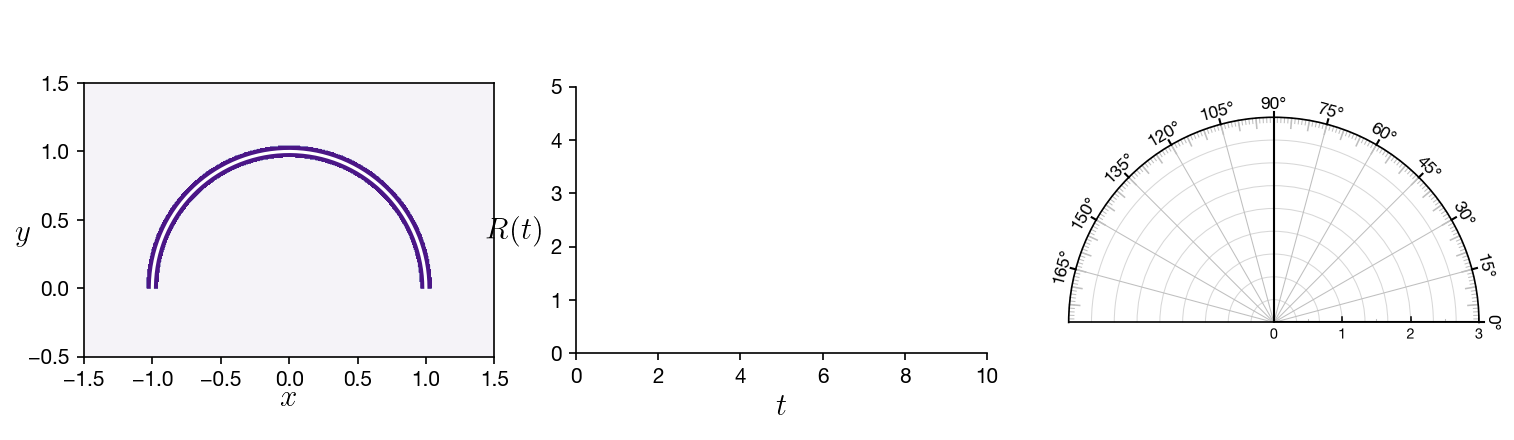

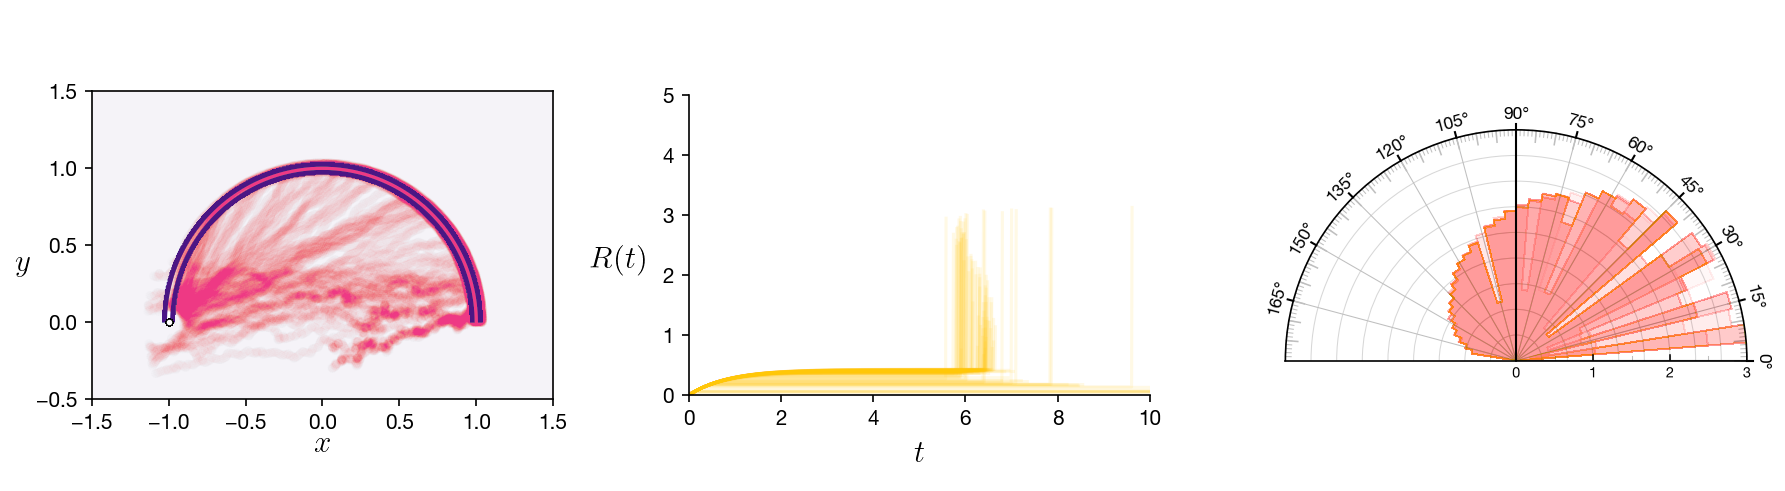

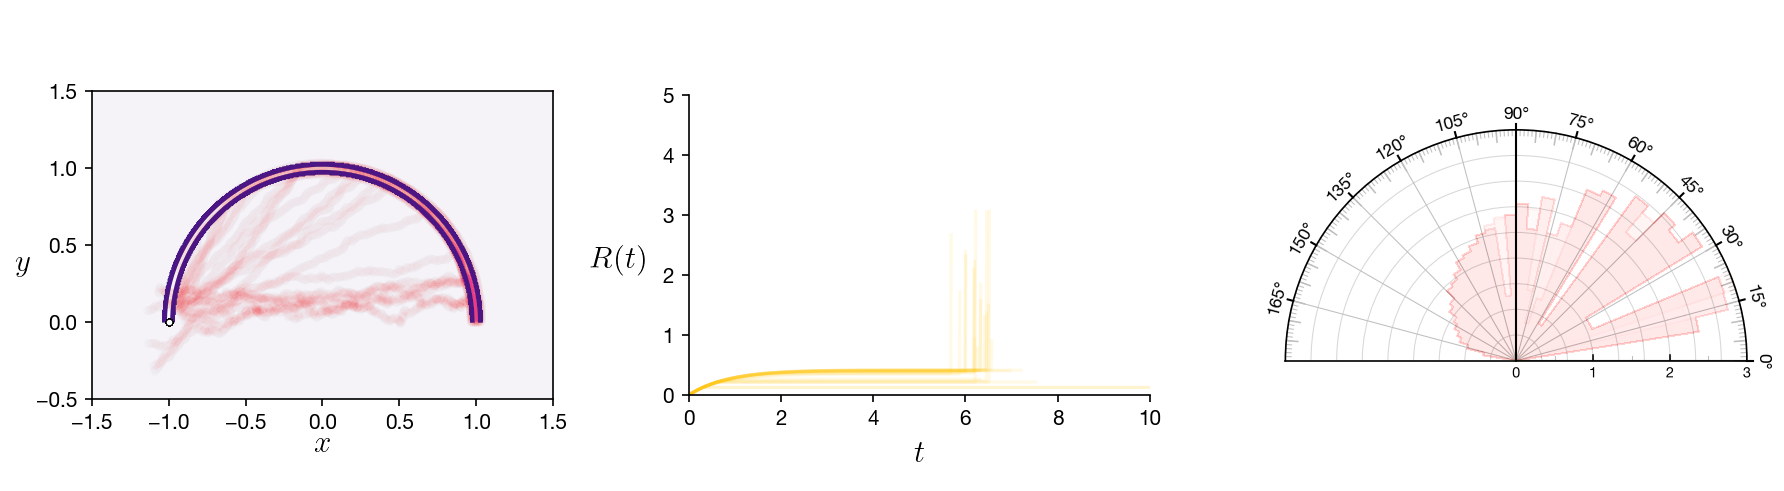

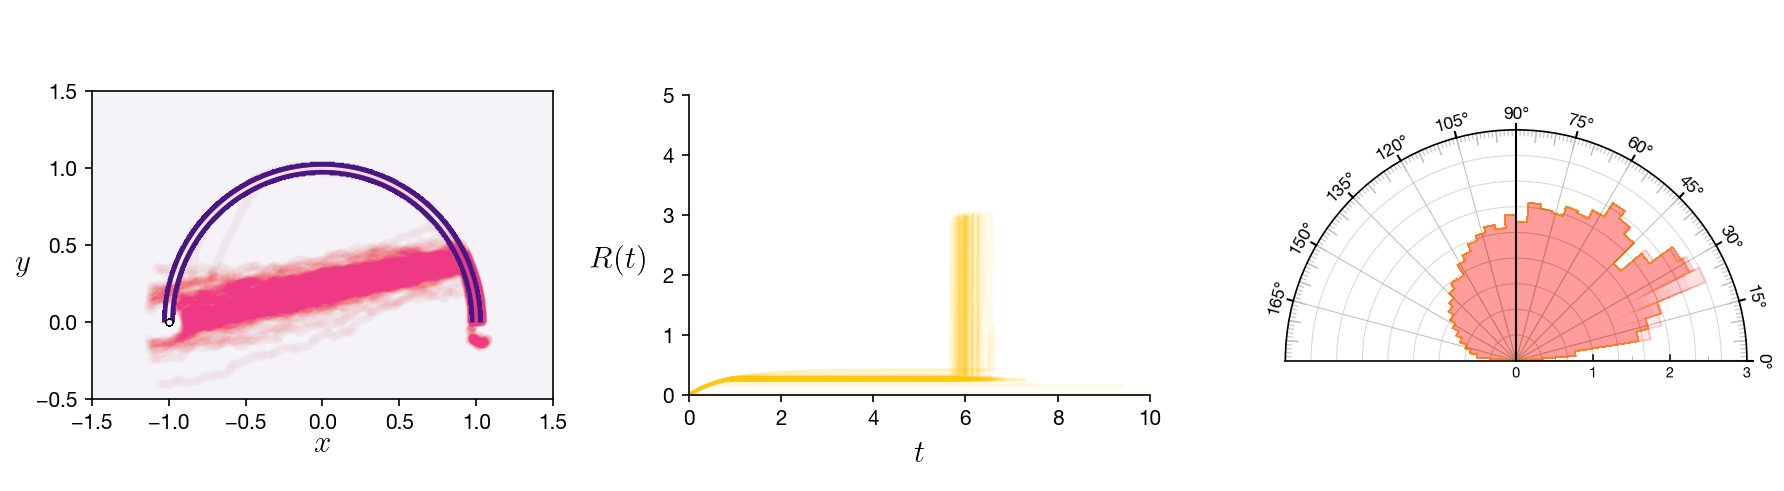

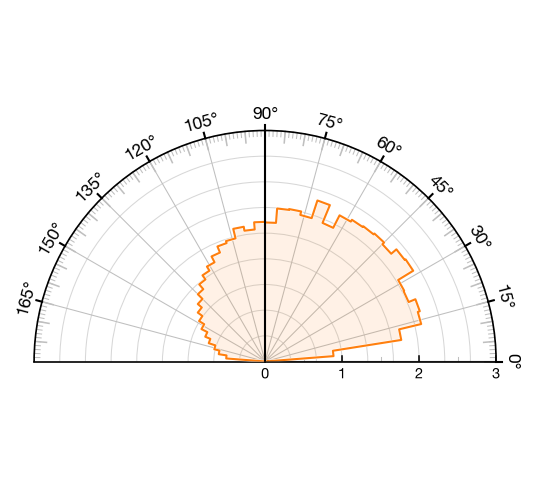

In [15]:
import importlib
importlib.reload(pF)
fig, ax = pF.plotRadial(3, p, valAvg)
plt.show()